# Pneuomonia Recognition

In [1]:
import numpy as np
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

Visualizziamo alcune immagini del dataset, target pari ad uno indicano un caso di Polmonite, 0 indica assenza di Polmonite

In [2]:
print("Number of images:", X.shape[0])
positive = 0
negative = 0

for i in range(X.shape[0]):
    if(y[i]==1):
        positive += 1
    if(y[i]==0):
        negative += 1

print("Number of positive cases:", positive)
print("Number of negative cases:", negative)

Number of images: 5232
Number of positive cases: 3883
Number of negative cases: 1349


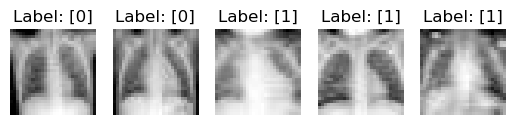

In [3]:
import matplotlib.pyplot as plt


# Visualizza alcune immagini
num_images_to_display = 5

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X))
    image = X[index]
    label = y[index]

    # Visualizza l'immagine con la sua etichetta
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Il dataset è sbilanciato verso le immagini con polmonite:

Circa il 74.2% delle immagini rappresentano casi di polmonite.
Circa il 25.8% delle immagini rappresentano casi negativi.

Andiamo a suddividere il train set tra training e test, utilizzando stratify per mantenere proporzione tra le classi

In [4]:
from sklearn.model_selection import train_test_split

# Suddivisione in set di addestramento e set di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A questo punto andiamo a dividere il Training Set in Training e Validation, mantenendo la stessa proporzione

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_valid.reshape(X_valid.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

Vado a normalizzare i dati dopo aver suddiviso Training, Validation e Test per evitare Data Leakage

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_normalized = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_normalized = scaler.transform(X_val_reshaped).reshape(X_valid.shape)
X_test_normalized = scaler.transform(X_test_reshaped).reshape(X_test.shape)

print(f"Normalized training set size: {X_train_normalized.shape}")
print(f"Normalized validation set size: {X_val_normalized.shape}")
print(f"Normalized test set size: {X_test_normalized.shape}")

Normalized training set size: (3348, 28, 28)
Normalized validation set size: (837, 28, 28)
Normalized test set size: (1047, 28, 28)


Essendo le classi sbilanciate, preferiamo una metrica come F1 rispetto ad Accuracy

In [8]:
from tensorflow.keras import backend as K

# Funzione per calcolare l'F1-score
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1

Definiamo una funzione per la stampa dei vari grafici

In [9]:
import matplotlib.pyplot as plt

def graphics(history):
    plt.figure(figsize=(12, 4))

    # Plot della perdita
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle metriche
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['f1_score'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

## Convolutional Neural Networks

Andiamo a eseguire il Training tramite Convolutional NN, utilizziamo una semplice CNN composta da 2 strati convoluzionali e uno strato Dense da 128 unità per la classificazione binaria, quest'ultima realizzata con un livello Dense di 1 unità con funzione di attivazione sigmoid.

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

In [11]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [12]:
# Stampa una rappresentazione del modello
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [13]:
# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

In [14]:
history = cnn1.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_data=(X_val_normalized, y_valid))

Epoch 1/50
105/105 [==============================] - 7s 47ms/step - loss: 0.3349 - accuracy: 0.8450 - f1_score: 0.8997 - val_loss: 0.2006 - val_accuracy: 0.9128 - val_f1_score: 0.9362
Epoch 2/50
105/105 [==============================] - 3s 31ms/step - loss: 0.1637 - accuracy: 0.9355 - f1_score: 0.9560 - val_loss: 0.1596 - val_accuracy: 0.9391 - val_f1_score: 0.9543
Epoch 3/50
105/105 [==============================] - 5s 45ms/step - loss: 0.1324 - accuracy: 0.9477 - f1_score: 0.9644 - val_loss: 0.1369 - val_accuracy: 0.9462 - val_f1_score: 0.9587
Epoch 4/50
105/105 [==============================] - 4s 38ms/step - loss: 0.1197 - accuracy: 0.9564 - f1_score: 0.9697 - val_loss: 0.1869 - val_accuracy: 0.9259 - val_f1_score: 0.9444
Epoch 5/50
105/105 [==============================] - 2s 17ms/step - loss: 0.1104 - accuracy: 0.9600 - f1_score: 0.9721 - val_loss: 0.1115 - val_accuracy: 0.9558 - val_f1_score: 0.9658
Epoch 6/50
105/105 [==============================] - 5s 43ms/step - loss: 

105/105 [==============================] - 4s 43ms/step - loss: 2.8665e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.1830 - val_accuracy: 0.9689 - val_f1_score: 0.9704
Epoch 46/50
105/105 [==============================] - 4s 42ms/step - loss: 2.6260e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.1843 - val_accuracy: 0.9689 - val_f1_score: 0.9703
Epoch 47/50
105/105 [==============================] - 4s 42ms/step - loss: 2.2767e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.9677 - val_f1_score: 0.9695
Epoch 48/50
105/105 [==============================] - 3s 27ms/step - loss: 1.9980e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.1919 - val_accuracy: 0.9677 - val_f1_score: 0.9697
Epoch 49/50
105/105 [==============================] - 1s 8ms/step - loss: 1.8329e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.1927 - val_accuracy: 0.9677 - val_f1_score: 0.9697
Epoch 50/50
105/105 [==============================] - 4s 34ms/

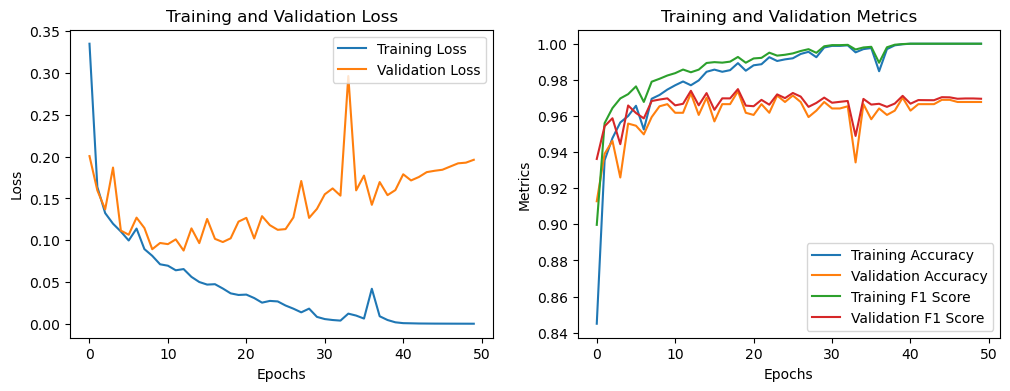

In [19]:
graphics(history)

27/27 [==============================] - 0s 2ms/step


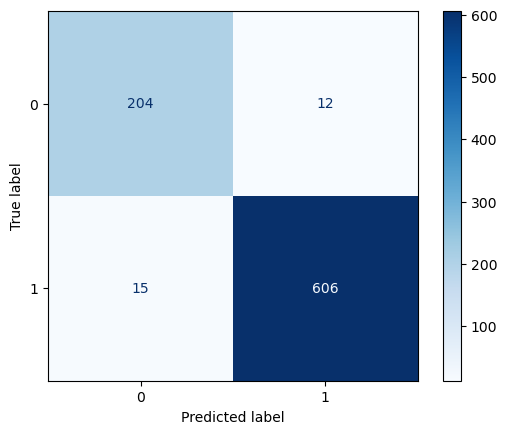

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = cnn1.predict(X_val_normalized)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_valid, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [18]:
test_loss, test_accuracy = cnn1.evaluate(X_test_normalized, y_test, batch_size=32)
print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")

SyntaxError: invalid syntax (1484095021.py, line 3)

Il modello, dalla curva riguardante la Validation Loss, mostra Overfitting, vista la dimensione ridotta del training set, applichiamo data Augmentation per renderlo più corposo. Per immagini mediche non è raccomandato l'uso di flip orizzontali, evitiamo quindi il suo utilizzo tra le possibili variazioni.

In [21]:
X_train_expand = np.expand_dims(X_train_normalized, axis=-1)
X_val_expand = np.expand_dims(X_val_normalized, axis=-1)
X_test_expand = np.expand_dims(X_test_normalized, axis=-1)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,  # Non riflettere lungo l'asse x per immagini mediche
    fill_mode='nearest'
)

# Definisci il generatore di dati per il set di validazione senza data augmentation
val_datagen = ImageDataGenerator()

# Assicurati di adattare i generatori ai tuoi dati
train_generator = train_datagen.flow(X_train_expand, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_expand, y_valid, batch_size=32)

Andiamo a vedere un paragone tra le immagini reali, e le immagini generate tramite il generatore.

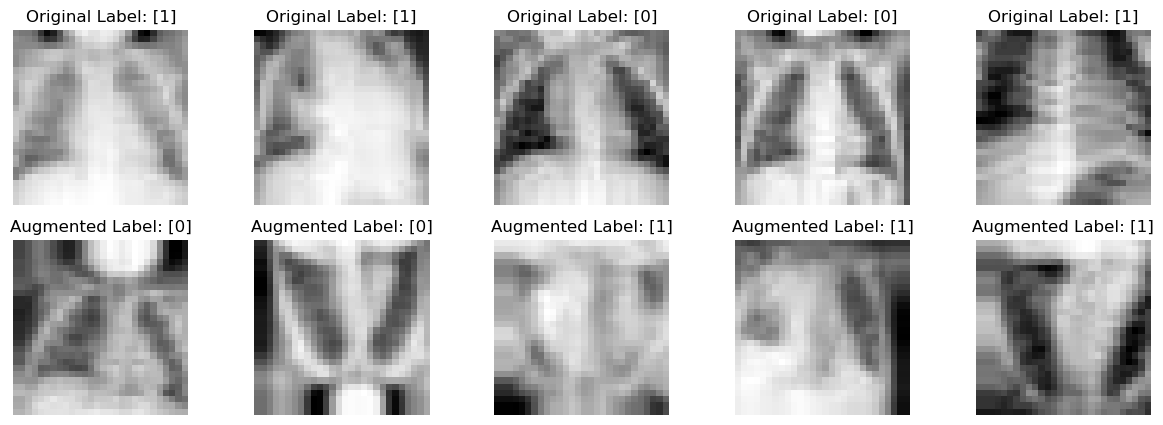

In [23]:
# Visualizza alcune immagini originali
num_images_to_display = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X_train))
    original_image = X_train[index]
    original_label = y_train[index]

    # Visualizza l'immagine originale con la sua etichetta
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Label: {original_label}")
    plt.axis('off')

# Visualizza alcune immagini generate
for i in range(num_images_to_display):
    augmented_data = next(train_generator)
    augmented_image = augmented_data[0][0]  # Ottieni l'immagine generata
    augmented_label = augmented_data[1][0]  # Ottieni l'etichetta generata

    # Visualizza l'immagine generata con la sua etichetta
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Label: {augmented_label}")
    plt.axis('off')

plt.show()

In [24]:
# Addestramento del modello con data augmentation
history2 = cnn1.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
)

Epoch 1/50
104/104 [==============================] - 7s 56ms/step - loss: 0.3173 - accuracy: 0.8839 - f1_score: 0.9207 - val_loss: 0.1424 - val_accuracy: 0.9447 - val_f1_score: 0.9613
Epoch 2/50
104/104 [==============================] - 5s 50ms/step - loss: 0.1830 - accuracy: 0.9282 - f1_score: 0.9507 - val_loss: 0.1265 - val_accuracy: 0.9507 - val_f1_score: 0.9655
Epoch 3/50
104/104 [==============================] - 4s 43ms/step - loss: 0.1573 - accuracy: 0.9367 - f1_score: 0.9569 - val_loss: 0.1295 - val_accuracy: 0.9531 - val_f1_score: 0.9671
Epoch 4/50
104/104 [==============================] - 5s 45ms/step - loss: 0.1445 - accuracy: 0.9427 - f1_score: 0.9610 - val_loss: 0.1330 - val_accuracy: 0.9447 - val_f1_score: 0.9615
Epoch 5/50
104/104 [==============================] - 4s 38ms/step - loss: 0.1318 - accuracy: 0.9454 - f1_score: 0.9623 - val_loss: 0.1380 - val_accuracy: 0.9471 - val_f1_score: 0.9627
Epoch 6/50
104/104 [==============================] - 5s 44ms/step - loss: 

104/104 [==============================] - 5s 48ms/step - loss: 0.0665 - accuracy: 0.9759 - f1_score: 0.9831 - val_loss: 0.1057 - val_accuracy: 0.9700 - val_f1_score: 0.9797
Epoch 46/50
104/104 [==============================] - 3s 33ms/step - loss: 0.0704 - accuracy: 0.9720 - f1_score: 0.9806 - val_loss: 0.1026 - val_accuracy: 0.9579 - val_f1_score: 0.9701
Epoch 47/50
104/104 [==============================] - 5s 45ms/step - loss: 0.0724 - accuracy: 0.9714 - f1_score: 0.9805 - val_loss: 0.1111 - val_accuracy: 0.9627 - val_f1_score: 0.9747
Epoch 48/50
104/104 [==============================] - 4s 42ms/step - loss: 0.0751 - accuracy: 0.9689 - f1_score: 0.9787 - val_loss: 0.0865 - val_accuracy: 0.9675 - val_f1_score: 0.9783
Epoch 49/50
104/104 [==============================] - 5s 48ms/step - loss: 0.0739 - accuracy: 0.9720 - f1_score: 0.9808 - val_loss: 0.0930 - val_accuracy: 0.9675 - val_f1_score: 0.9774
Epoch 50/50
104/104 [==============================] - 5s 46ms/step - loss: 0.0665

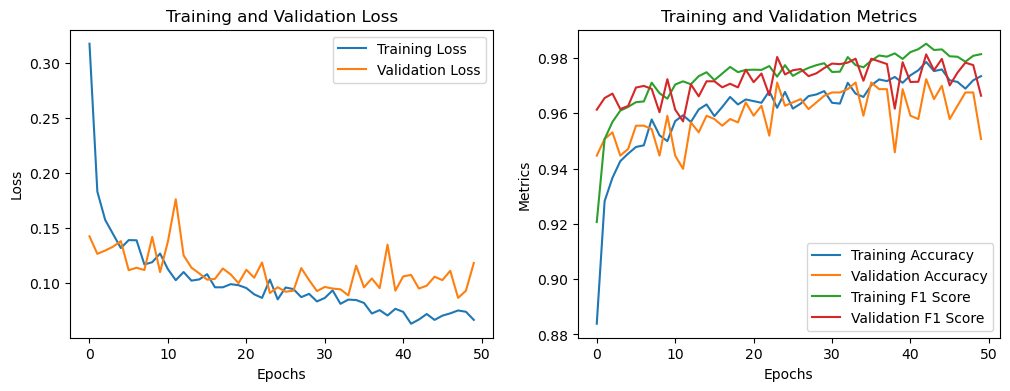

In [26]:
graphics(history2)

La curva della Validation Loss scende molto meglio, la Data Augmentation ha contribuito a diminuire l'Overfitting.
Proviamo ora un modello più performante, scegliendo un modello VGG-Like, inoltre aggiungiamo la CallBack di Early Stopping come metodo di regolarizzazione.

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
cnn2 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [35]:
# Compilazione del modello
cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

# Definizione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 8)         80        
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [36]:
# Addestramento del modello
history3 = cnn2.fit( train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping])

Epoch 1/50
104/104 [==============================] - 9s 72ms/step - loss: 0.4661 - accuracy: 0.7799 - f1_score: 0.8544 - val_loss: 0.3051 - val_accuracy: 0.8942 - val_f1_score: 0.9237
Epoch 2/50
104/104 [==============================] - 7s 66ms/step - loss: 0.3084 - accuracy: 0.8628 - f1_score: 0.9071 - val_loss: 0.2026 - val_accuracy: 0.9147 - val_f1_score: 0.9401
Epoch 3/50
104/104 [==============================] - 6s 56ms/step - loss: 0.2402 - accuracy: 0.8932 - f1_score: 0.9270 - val_loss: 0.1963 - val_accuracy: 0.9267 - val_f1_score: 0.9482
Epoch 4/50
104/104 [==============================] - 6s 56ms/step - loss: 0.2212 - accuracy: 0.9071 - f1_score: 0.9365 - val_loss: 0.2028 - val_accuracy: 0.9183 - val_f1_score: 0.9418
Epoch 5/50
104/104 [==============================] - 6s 59ms/step - loss: 0.1861 - accuracy: 0.9252 - f1_score: 0.9481 - val_loss: 0.1487 - val_accuracy: 0.9471 - val_f1_score: 0.9643
Epoch 6/50
104/104 [==============================] - 6s 59ms/step - loss: 

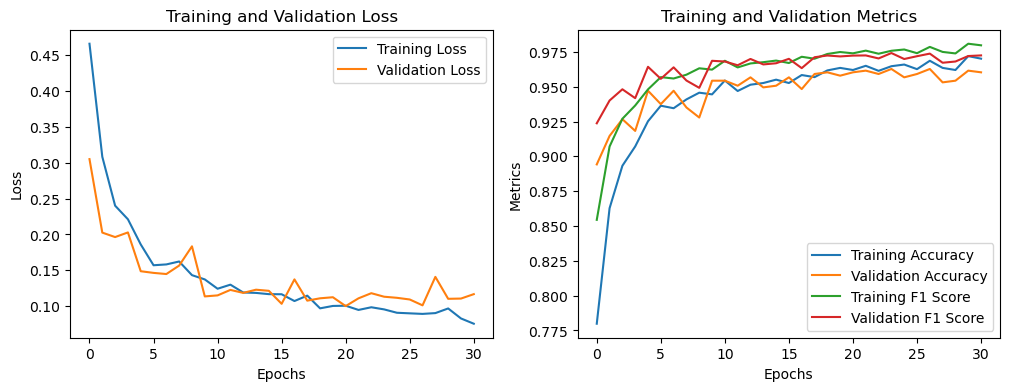

In [47]:
graphics(history3)

Introduco ora un learning rate decrescente, inizializzazione dei pesi He ed infine 

In [49]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

In [53]:
cnn2_tune = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dense(1, activation='sigmoid')
])

In [54]:
# Compilazione del modello
cnn2_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2_tune.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                      

In [55]:
history4 = cnn2_tune.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=80,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/80
104/104 [==============================] - 8s 54ms/step - loss: 1.2078 - accuracy: 0.8902 - f1_score: 0.9229 - val_loss: 1.5538 - val_accuracy: 0.7464 - val_f1_score: 0.8522 - lr: 0.0010
Epoch 2/80
104/104 [==============================] - 5s 49ms/step - loss: 0.8763 - accuracy: 0.9324 - f1_score: 0.9540 - val_loss: 0.9474 - val_accuracy: 0.8594 - val_f1_score: 0.9129 - lr: 0.0010
Epoch 3/80
104/104 [==============================] - 5s 50ms/step - loss: 0.6895 - accuracy: 0.9427 - f1_score: 0.9609 - val_loss: 0.6564 - val_accuracy: 0.9315 - val_f1_score: 0.9552 - lr: 0.0010
Epoch 4/80
104/104 [==============================] - 5s 44ms/step - loss: 0.5510 - accuracy: 0.9508 - f1_score: 0.9662 - val_loss: 0.4889 - val_accuracy: 0.9507 - val_f1_score: 0.9665 - lr: 0.0010
Epoch 5/80
104/104 [==============================] - 5s 46ms/step - loss: 0.4519 - accuracy: 0.9521 - f1_score: 0.9667 - val_loss: 0.4513 - val_accuracy: 0.9411 - val_f1_score: 0.9584 - lr: 0.0010
Epoch 6/80

Epoch 42/80
104/104 [==============================] - 6s 54ms/step - loss: 0.0940 - accuracy: 0.9861 - f1_score: 0.9903 - val_loss: 0.1404 - val_accuracy: 0.9675 - val_f1_score: 0.9778 - lr: 1.0000e-04
Epoch 43/80
104/104 [==============================] - 5s 47ms/step - loss: 0.0938 - accuracy: 0.9861 - f1_score: 0.9907 - val_loss: 0.1335 - val_accuracy: 0.9688 - val_f1_score: 0.9780 - lr: 1.0000e-04
Epoch 44/80
104/104 [==============================] - 5s 48ms/step - loss: 0.0968 - accuracy: 0.9849 - f1_score: 0.9898 - val_loss: 0.1374 - val_accuracy: 0.9663 - val_f1_score: 0.9763 - lr: 1.0000e-04
Epoch 45/80
104/104 [==============================] - 5s 49ms/step - loss: 0.0920 - accuracy: 0.9858 - f1_score: 0.9903 - val_loss: 0.1358 - val_accuracy: 0.9675 - val_f1_score: 0.9776 - lr: 1.0000e-04
Epoch 46/80
104/104 [==============================] - 6s 54ms/step - loss: 0.0904 - accuracy: 0.9858 - f1_score: 0.9904 - val_loss: 0.1365 - val_accuracy: 0.9663 - val_f1_score: 0.9769 - 

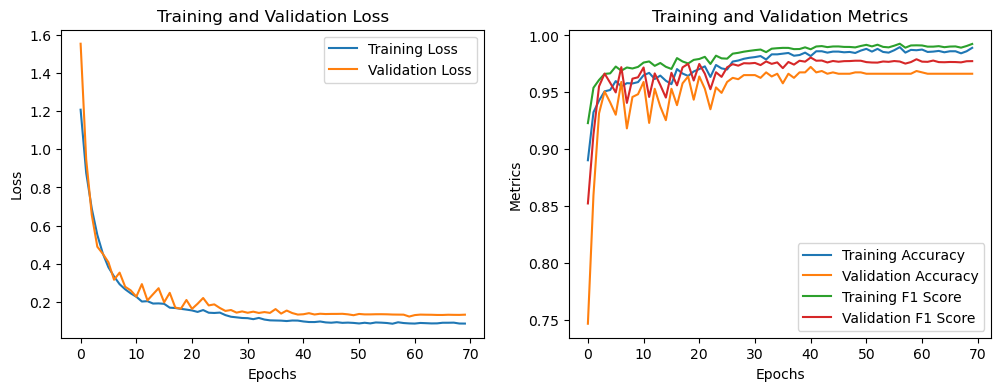

In [56]:
graphics(history4)

In [64]:
test_loss, test_accuracy, test_f1 = cnn2_tune.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9599 - f1_score: 0.9729
Loss sul set di test: 0.15693019330501556
Accuracy sul set di test: 0.9598853588104248
F1 Score sul set di test: 0.97288578748703


33/33 [==============================] - 0s 3ms/step


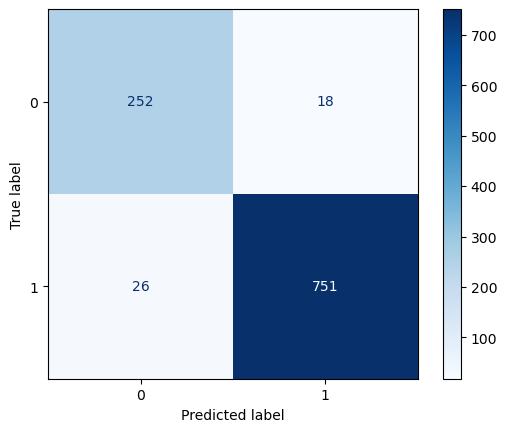

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = cnn1.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [75]:
from tensorflow.keras.layers import Dropout

In [80]:
cnn3 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [81]:
# Compilazione del modello
cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 8)         0         
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 14, 14, 16)     

In [82]:
history5 = cnn3.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/120
104/104 [==============================] - 8s 56ms/step - loss: 1.7003 - accuracy: 0.8589 - f1_score: 0.9034 - val_loss: 4.0338 - val_accuracy: 0.7404 - val_f1_score: 0.8487 - lr: 0.0010
Epoch 2/120
104/104 [==============================] - 5s 52ms/step - loss: 1.3983 - accuracy: 0.8896 - f1_score: 0.9244 - val_loss: 5.4174 - val_accuracy: 0.7428 - val_f1_score: 0.8490 - lr: 0.0010
Epoch 3/120
104/104 [==============================] - 11s 102ms/step - loss: 1.1975 - accuracy: 0.9047 - f1_score: 0.9344 - val_loss: 4.6538 - val_accuracy: 0.7440 - val_f1_score: 0.8503 - lr: 0.0010
Epoch 4/120
104/104 [==============================] - 8s 74ms/step - loss: 1.0386 - accuracy: 0.9279 - f1_score: 0.9513 - val_loss: 2.5904 - val_accuracy: 0.7452 - val_f1_score: 0.8519 - lr: 0.0010
Epoch 5/120
104/104 [==============================] - 7s 62ms/step - loss: 0.9139 - accuracy: 0.9340 - f1_score: 0.9547 - val_loss: 1.4423 - val_accuracy: 0.7969 - val_f1_score: 0.8777 - lr: 0.0010
Epo

Epoch 42/120
104/104 [==============================] - 4s 40ms/step - loss: 0.2034 - accuracy: 0.9677 - f1_score: 0.9781 - val_loss: 0.2421 - val_accuracy: 0.9531 - val_f1_score: 0.9690 - lr: 0.0010
Epoch 43/120
104/104 [==============================] - 7s 64ms/step - loss: 0.2193 - accuracy: 0.9611 - f1_score: 0.9733 - val_loss: 0.2199 - val_accuracy: 0.9627 - val_f1_score: 0.9740 - lr: 0.0010
Epoch 44/120
104/104 [==============================] - 5s 52ms/step - loss: 0.2014 - accuracy: 0.9623 - f1_score: 0.9745 - val_loss: 0.2329 - val_accuracy: 0.9555 - val_f1_score: 0.9688 - lr: 0.0010
Epoch 45/120
104/104 [==============================] - 6s 55ms/step - loss: 0.2027 - accuracy: 0.9662 - f1_score: 0.9770 - val_loss: 0.1963 - val_accuracy: 0.9639 - val_f1_score: 0.9745 - lr: 0.0010
Epoch 46/120
104/104 [==============================] - 5s 47ms/step - loss: 0.2012 - accuracy: 0.9626 - f1_score: 0.9743 - val_loss: 0.2132 - val_accuracy: 0.9471 - val_f1_score: 0.9631 - lr: 0.0010


104/104 [==============================] - 5s 44ms/step - loss: 0.1272 - accuracy: 0.9807 - f1_score: 0.9864 - val_loss: 0.1615 - val_accuracy: 0.9603 - val_f1_score: 0.9727 - lr: 1.0000e-04
Epoch 83/120
104/104 [==============================] - 7s 70ms/step - loss: 0.1232 - accuracy: 0.9816 - f1_score: 0.9871 - val_loss: 0.1516 - val_accuracy: 0.9688 - val_f1_score: 0.9789 - lr: 1.0000e-04
Epoch 84/120
104/104 [==============================] - 6s 53ms/step - loss: 0.1242 - accuracy: 0.9798 - f1_score: 0.9859 - val_loss: 0.1493 - val_accuracy: 0.9675 - val_f1_score: 0.9779 - lr: 1.0000e-04
Epoch 85/120
104/104 [==============================] - 5s 45ms/step - loss: 0.1311 - accuracy: 0.9765 - f1_score: 0.9837 - val_loss: 0.1471 - val_accuracy: 0.9688 - val_f1_score: 0.9787 - lr: 1.0000e-04
Epoch 86/120
104/104 [==============================] - 7s 63ms/step - loss: 0.1199 - accuracy: 0.9828 - f1_score: 0.9883 - val_loss: 0.1513 - val_accuracy: 0.9663 - val_f1_score: 0.9766 - lr: 1.00

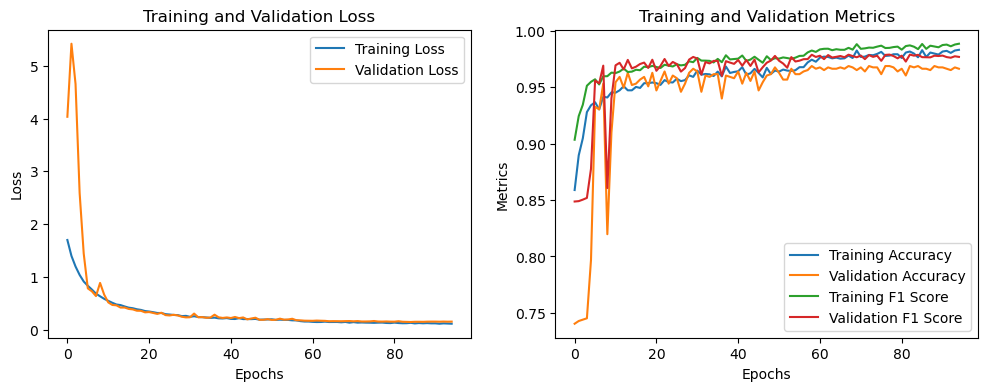

In [83]:
graphics(history5)

In [84]:
test_loss, test_accuracy, test_f1 = cnn3.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 11ms/step - loss: 0.1594 - accuracy: 0.9704 - f1_score: 0.9797
Loss sul set di test: 0.15941400825977325
Accuracy sul set di test: 0.970391571521759
F1 Score sul set di test: 0.979720413684845
